In [1]:
# Insurance policies
NO_INSURANCE = ("Nothing", 0, lambda x: x)

POLICIES = (
    ("Stayin Alive", 2000, lambda x: 0),
    ("Be Immortal",  1500, lambda x: min(500, x)),
    ("Risk It",      1000, lambda x:.25 * x),
    NO_INSURANCE
)

In [2]:
# Value and events

LIFE = 200000

P_SICK = .05

LEVELS_PROBS = list(zip((.1, .2, .3), (.5, .4, .1)))




In [3]:
# Tree

from pyne import Event, Transition
from pyne.strategy import createMaxExpected


# Being sick without Insurance
policy = NO_INSURANCE

name, cost, costFunction = policy

howSick = Event("How Sick")


for l, p in LEVELS_PROBS:
    cost = LIFE * l
    costAfterPolicy = costFunction(cost)
    howSick.transitions.append(
        Transition("{:.0%} loss".format(l), probability=p, payout=-costAfterPolicy)
    )


root = howSick

In [4]:
# Solve
strategy = createMaxExpected()

root.createPlaceholders()
root.propagatePayouts(0)
root.computePossibilities(strategy)
root.propagateEndgameDistribution(1)

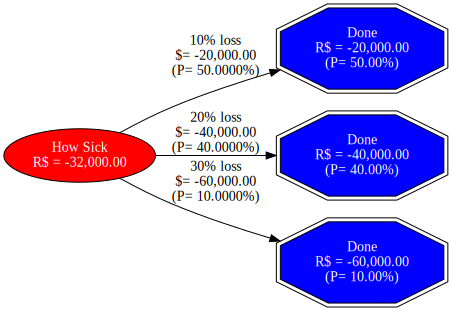

In [5]:
# Visualize
import graphviz
from pyne.render import GraphvizEngine

eng = GraphvizEngine(root)
graph = eng.render("svg")

graphviz.Source(graph)

In [6]:
# Being sick - Generalized

def fallingSick(policy):
    costFunction = policy[2]

    howSick = Event("How Sick")

    for l, p in LEVELS_PROBS:
        cost = LIFE * l
        costAfterPolicy = costFunction(cost)
        howSick.transitions.append(
            Transition("{:.0%} loss".format(l), probability=p, payout=-costAfterPolicy)
        )
        
    getSick = Event("Get Sick ?", (
        Transition("Yes", probability=P_SICK, target=howSick),
        Transition("No"),        
    ))
    return getSick

In [7]:
# Adding choices:

from pyne import Decision

whatPolicy = Decision("What Policy ?")
for pol in POLICIES:
    name, cost, costFunction = pol
    whatPolicy.transitions.append(Transition(name, -cost, target=fallingSick(pol)))
    
root = whatPolicy

In [8]:
# Solve
strategy = createMaxExpected()

root.createPlaceholders()
root.propagatePayouts(0)
root.computePossibilities(strategy)
root.propagateEndgameDistribution(1)

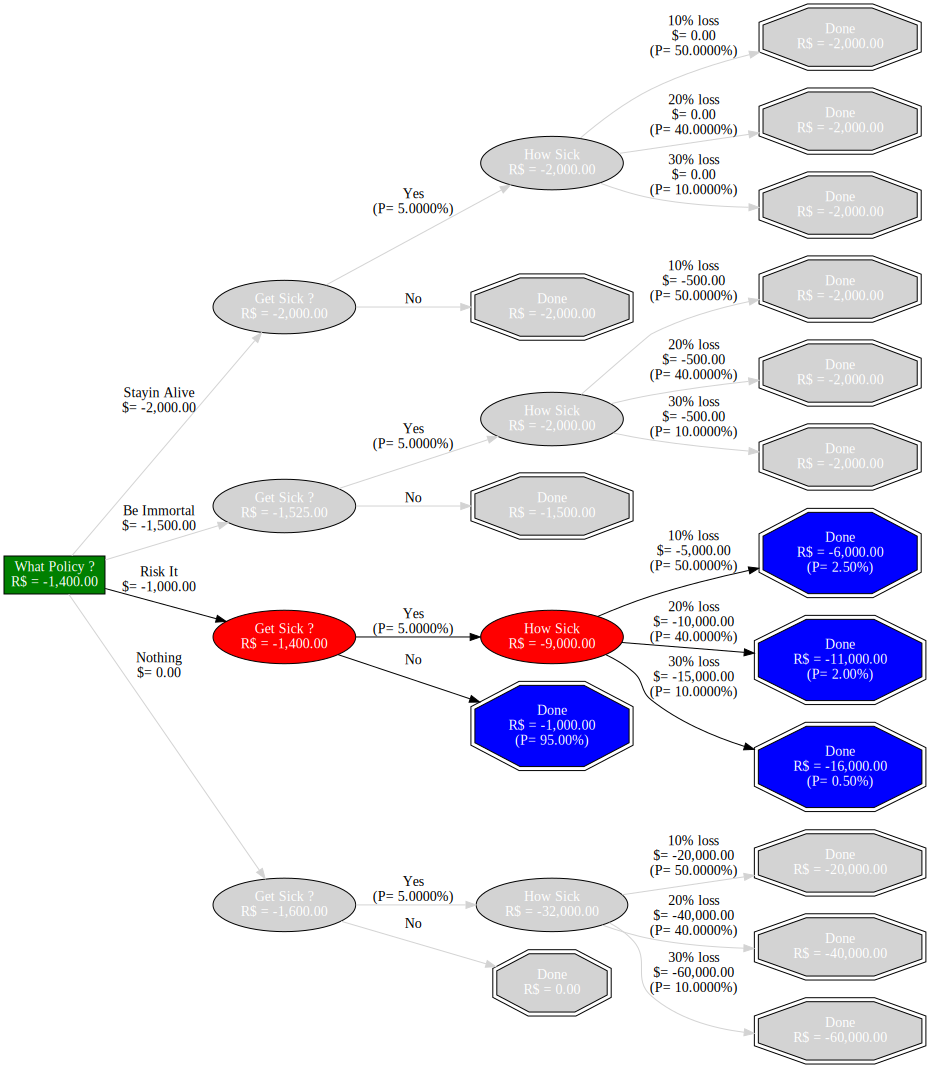

In [9]:
# Visualize
import graphviz
from pyne.render import GraphvizEngine

eng = GraphvizEngine(root)
graph = eng.render("svg")

graphviz.Source(graph)

In [10]:
# So... the result is ?
print("The best policy is {} with an expected cost of {:,.2f} $".format(whatPolicy.results.choice.name, -whatPolicy.results.reducedPayout))

print("Other options:")

otherOptions = [t for t in whatPolicy.transitions if t is not whatPolicy.results.choice]
otherOptions = sorted(otherOptions, key=lambda t: t.target.results.reducedPayout, reverse=True)
for op in otherOptions:
    print("    {:12}: {:-,.2f} $".format(op.name, -op.target.results.reducedPayout))

The best policy is Risk It with an expected cost of 1,400.00 $
Other options:
    Be Immortal : 1,525.00 $
    Nothing     : 1,600.00 $
    Stayin Alive: 2,000.00 $


In [11]:
# Distribution plot
from pyne import EndGame

import pandas as pd
import seaborn as sb


endGames = (n for n in whatPolicy.getNodesFlat() if isinstance(n, EndGame) and hasattr(n.results, "probability"))
possibilities = [(eg.results.probability, eg.results.reducedPayout) for eg in endGames]

df = pd.DataFrame(possibilities, columns="prob payout".split())

sb.barplot("payout", "prob", data=df)

In [12]:
# Being sick - Generalized
strategy = createMaxExpected()

def resolveForSickProb(pSick):

    def fallingSick(policy):
        costFunction = policy[2]

        howSick = Event("Get Sick")

        for l, p in LEVELS_PROBS:
            cost = LIFE * l
            costAfterPolicy = costFunction(cost)
            howSick.transitions.append(
                Transition("{:.0%} loss".format(l), probability=p, payout=-costAfterPolicy)
            )

        getSick = Event("Get Sick ?", (
            Transition("Yes", probability=pSick, target=howSick),
            Transition("No"),

        ))
        return getSick

    # Adding choices:

    whatPolicy = Decision("What Policy ?")
    for pol in POLICIES:
        name, cost, costFunction = pol
        whatPolicy.transitions.append(Transition(name, -cost, target=fallingSick(pol)))

    root = whatPolicy
    
    # Solve

    root.createPlaceholders()
    root.propagatePayouts(0)
    root.computePossibilities(strategy)
    root.propagateEndgameDistribution(1)
    
    bestPolicy = whatPolicy.results.choice.name
    costs = [t.target.results.reducedPayout for t in whatPolicy.transitions]
    
    return (bestPolicy, *costs)


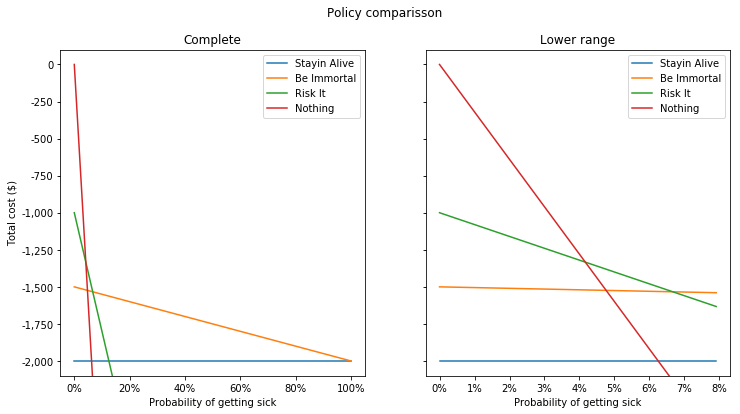

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
probs = np.linspace(0,1, 1000)

names = [t.name for t in whatPolicy.transitions]

df = pd.DataFrame([(p, *resolveForSickProb(p)) for p in probs], columns=("prob", "best", *names))

fig, axs = plt.subplots(1,2, sharey=True, figsize=(12,6))
fig.suptitle("Policy comparisson")
ax=axs[0]
df.plot(x="prob", ylim=(-2100, 100), title="Complete",ax=ax)
ax.set(xlabel="Probability of getting sick", ylabel="Total cost ($)")
ax.xaxis.set_major_formatter(FuncFormatter("{:.0%}".format))
ax.yaxis.set_major_formatter(FuncFormatter("{:,.0f}".format))

ax=axs[1]
df[df.prob<.08].plot(x="prob", ylim=(-2100, 100), title="Lower range",ax=ax)
ax.set(xlabel="Probability of getting sick", ylabel="Total cost ($)")
ax.xaxis.set_major_formatter(FuncFormatter("{:.0%}".format))
ax.yaxis.set_major_formatter(FuncFormatter("{:,.0f}".format))

